#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행
    * 성능 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.

## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

* 함수 생성

In [3]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - 데이터프레임에 대한 기본 정보를 확인합니다.( .head(), .shape 등)

#### 1) 데이터 로딩

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_csv('/content/drive/MyDrive/KT_MP3/data01_train.csv')

In [6]:
data.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [8]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [9]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [10]:
data.isna().sum().sum()

0

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


In [11]:
data1 = data.copy()
data1['Activity'] = np.where(data1['Activity'].isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']), 1, 0)

In [12]:
data1['Activity'].value_counts()

0    3234
1    2647
Name: Activity, dtype: int64

### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [13]:
target = 'Activity'
x = data1.drop(target, axis=1)
y = data1[target]

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=44)

### (2) 스케일링(필요시)


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [15]:
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.fit_transform(x_test)

## **3. 기본 모델링**



* 세부 요구사항
    - 최소 4개 이상의 알고리즘을 적용하여 모델링을 수행한다.
    - 각 알고리즘별로 전체 변수로 모델링, 상위 N개 변수를 선택하여 모델링을 수행하고 성능 비교를 한다.
    - (옵션) 알고리즘 중 1~2개에 대해서, 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것이다.

### (1) 알고리즘1 : RandomForest

In [16]:
result = {}

In [17]:
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'log2']
# }

# model_rf = RandomForestClassifier()

# grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search_rf.fit(x_train, y_train)

In [18]:
model_rf = RandomForestClassifier()
model_rf.fit(x_train, y_train)

RandomForestClassifier()

In [19]:
y_pred_rf = model_rf.predict(x_test)

In [20]:
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[644   0]
 [  0 533]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       644
           1       1.00      1.00      1.00       533

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [21]:
result['RandomForest'] = accuracy_score(y_test, y_pred_rf)

,feature_name,feature_importance
0,tBodyAcc-max()-X,0.079812
1,tBodyAccJerk-energy()-X,0.059854
2,fBodyAcc-mean()-X,0.039743
3,fBodyAccJerk-max()-X,0.030077
4,tBodyAccJerk-entropy()-X,0.029983
...,...,...
556,fBodyAcc-entropy()-Z,0.000000
557,fBodyAcc-entropy()-Y,0.000000
558,"tBodyAccJerk-arCoeff()-Z,1",0.000000
559,fBodyAcc-iqr()-Z,0.000000


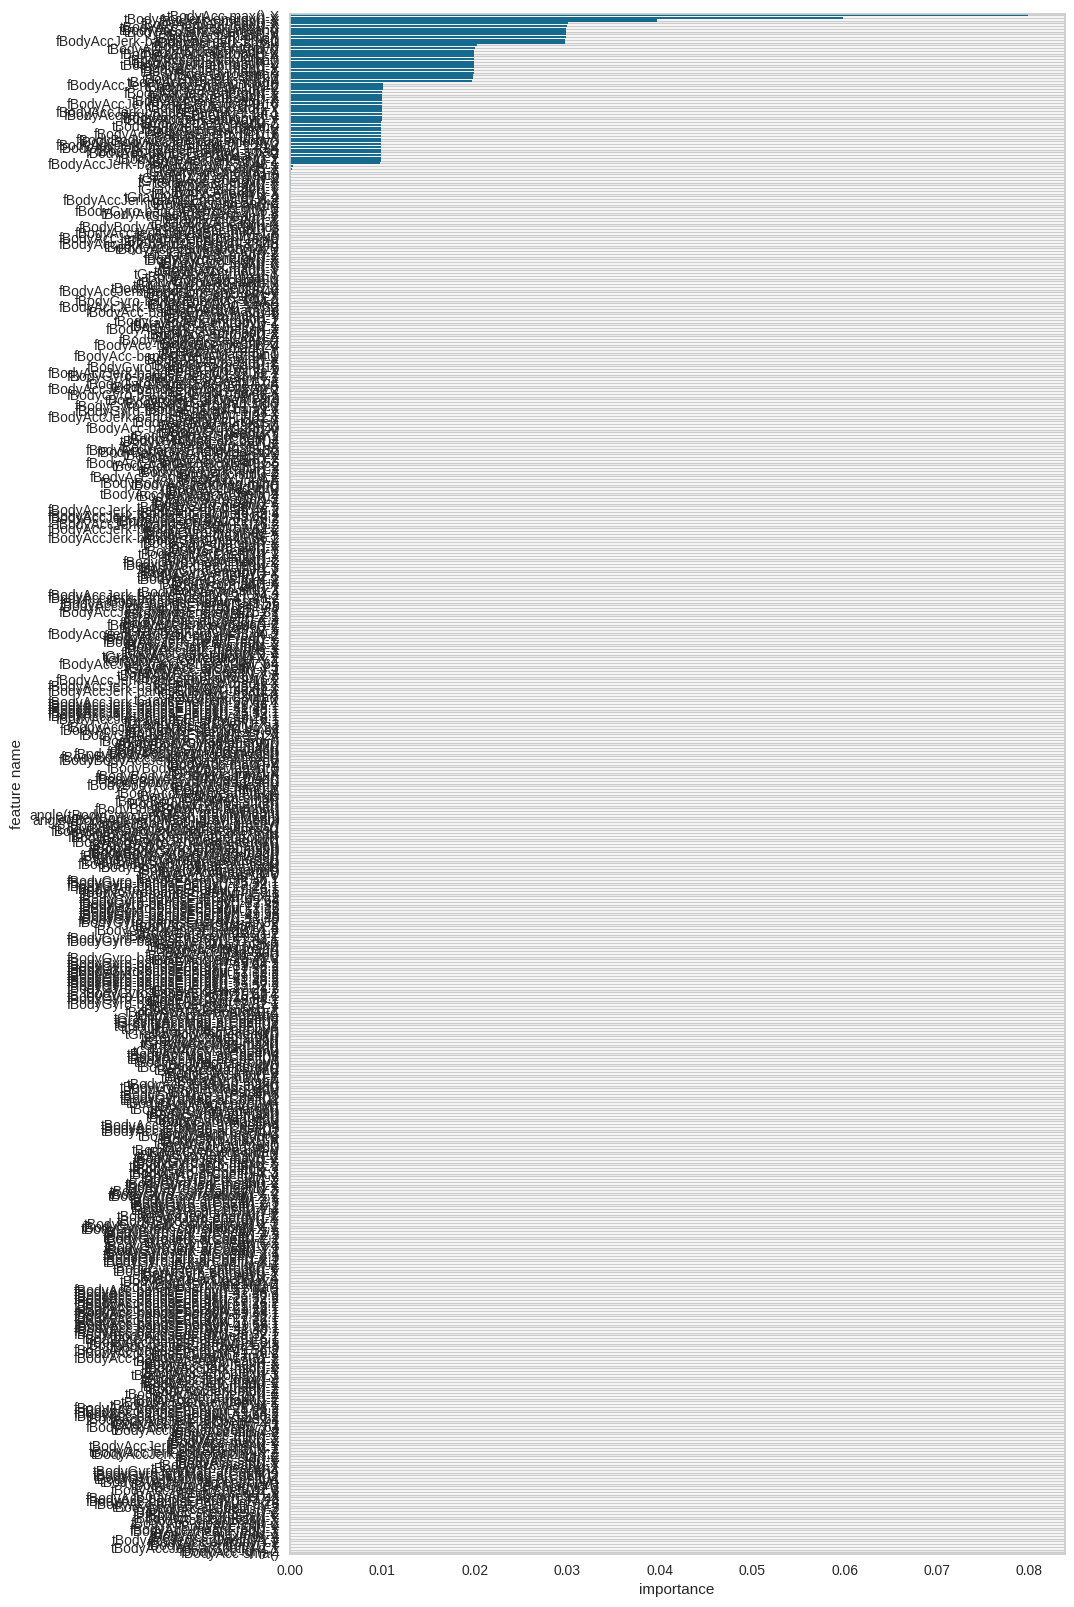

In [22]:
plot_feature_importance(model_rf.feature_importances_, x_train.columns)

### (2) 알고리즘2 : DecisionTree

In [23]:
model_dt = DecisionTreeClassifier()
model_dt.fit(x_train, y_train)

DecisionTreeClassifier()

In [24]:
y_pred_dt = model_dt.predict(x_test)

In [25]:
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

[[644   0]
 [  1 532]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       644
           1       1.00      1.00      1.00       533

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [26]:
result['DecisionTree'] = accuracy_score(y_test, y_pred_dt)

,feature_name,feature_importance
0,"fBodyAccJerk-bandsEnergy()-1,16",0.999141
1,"angle(X,gravityMean)",0.000859
2,tBodyAcc-mean()-X,0.000000
3,fBodyAccJerk-skewness()-Y,0.000000
4,fBodyAccJerk-maxInds-Z,0.000000
...,...,...
556,tBodyGyroJerk-iqr()-Z,0.000000
557,tBodyGyroJerk-iqr()-Y,0.000000
558,tBodyGyroJerk-iqr()-X,0.000000
559,tBodyGyroJerk-energy()-Z,0.000000


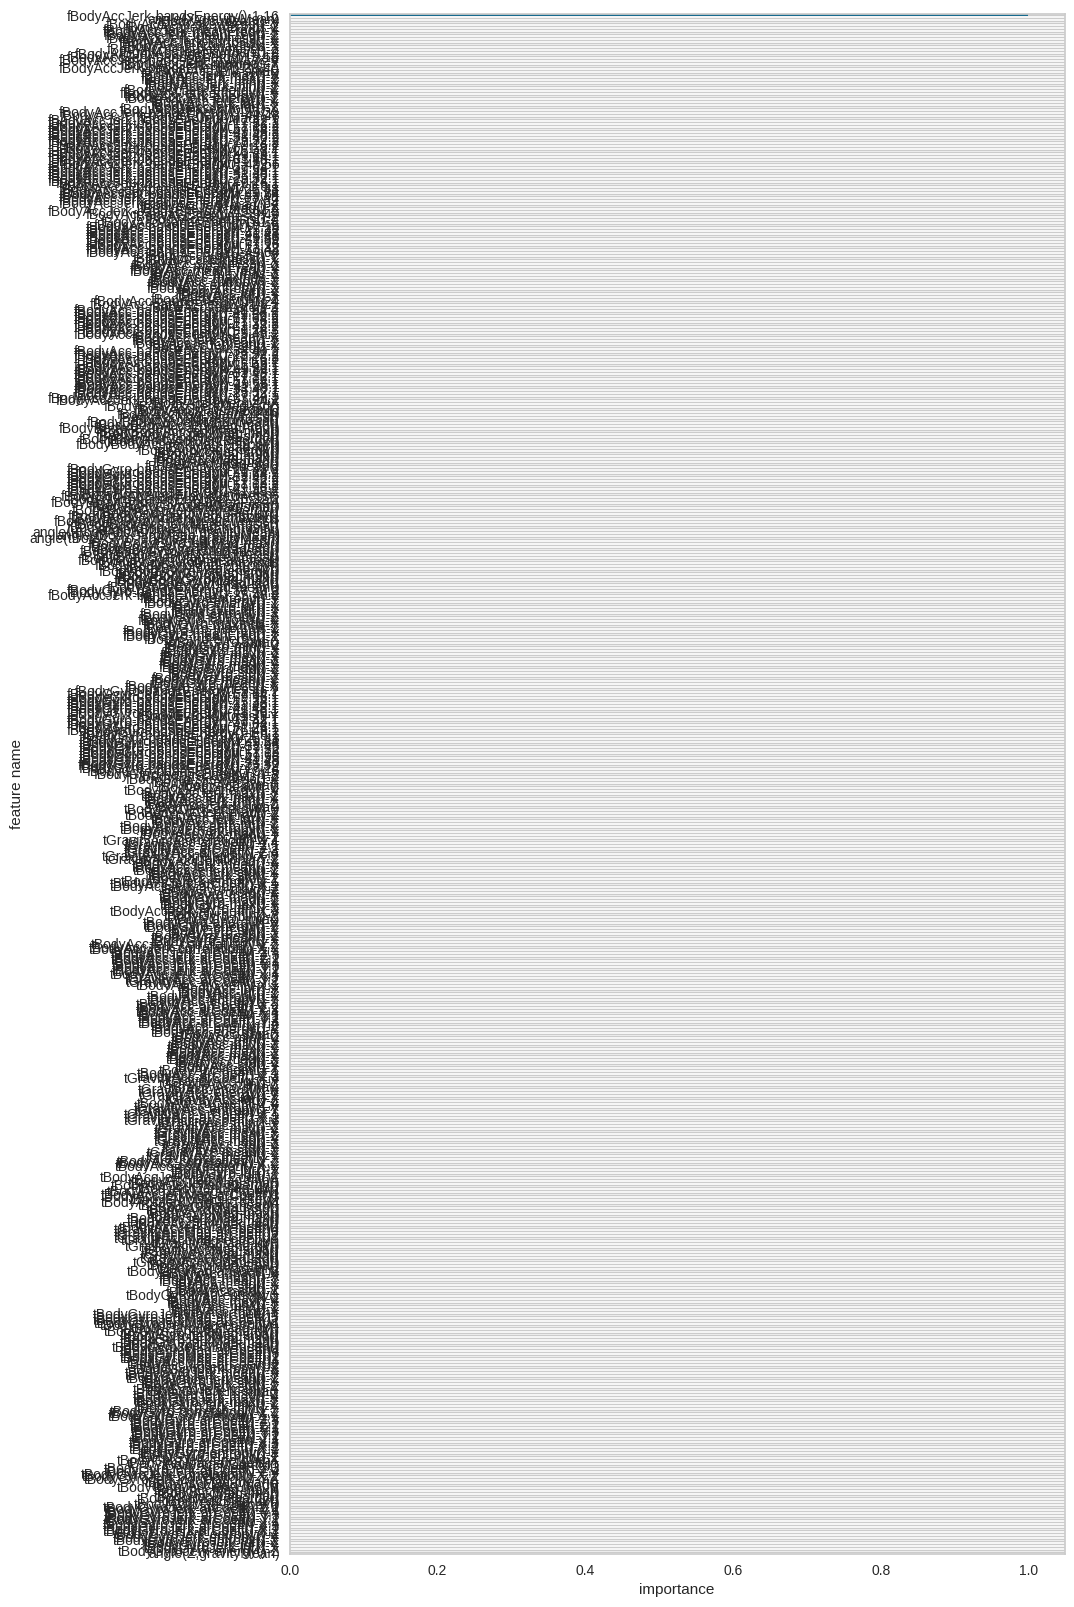

In [27]:
plot_feature_importance(model_dt.feature_importances_, x_train.columns)

### (3) 알고리즘3 : KNN

In [28]:
model_knn = KNeighborsClassifier()

In [29]:
model_knn.fit(x_train_s, y_train)

KNeighborsClassifier()

In [30]:
y_pred_knn = model_knn.predict(x_test_s)

In [31]:
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

[[644   0]
 [  0 533]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       644
           1       1.00      1.00      1.00       533

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



### (4) 알고리즘4 : XGBoost

In [32]:
model_xgb = XGBClassifier()
model_xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
y_pred_xgb = model_xgb.predict(x_test)

In [34]:
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

[[644   0]
 [  1 532]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       644
           1       1.00      1.00      1.00       533

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [35]:
booster = model_xgb.get_booster()

In [36]:
importance = booster.get_score(importance_type='weight')
importance

{'tBodyAcc-mean()-Z': 1.0,
 'tBodyAcc-max()-X': 6.0,
 'tBodyAcc-correlation()-X,Z': 1.0,
 'tGravityAcc-entropy()-Y': 1.0,
 'tBodyAccJerk-iqr()-X': 1.0,
 'tBodyAccJerk-iqr()-Y': 1.0,
 'tBodyGyro-std()-Y': 1.0,
 'tBodyGyro-iqr()-X': 1.0,
 'tBodyAccMag-arCoeff()2': 1.0,
 'fBodyAcc-bandsEnergy()-9,16': 1.0,
 'fBodyAccJerk-max()-X': 3.0,
 'fBodyAccJerk-bandsEnergy()-1,8': 6.0,
 'fBodyAccJerk-bandsEnergy()-1,16': 9.0,
 'fBodyAccJerk-bandsEnergy()-1,24': 1.0,
 'fBodyGyro-bandsEnergy()-1,16.1': 1.0}

In [37]:
result['XGBoost'] = accuracy_score(y_test, y_pred_xgb)

### (5) 알고리즘5: AutoML이용

In [86]:
# !pip install pycaret --quiet
# !pip install shap --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 12.2 MB/s eta 0:00:00


In [93]:
# !pip install scikit-learn==1.4.1.post1

In [1]:
from pycaret.classification import *

In [38]:
s = setup(data = x_train, target = y_train, session_id=123)

,Description,Value
0,Session id,123
1,Target,Activity
2,Target type,Binary
3,Original data shape,"(4704, 562)"
4,Transformed data shape,"(4704, 562)"
5,Transformed train set shape,"(3292, 562)"
6,Transformed test set shape,"(1412, 562)"
7,Numeric features,561
8,Preprocess,True
9,Imputation type,simple


In [40]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9997,0.0000,1.0000,0.9993,0.9997,0.9994,0.9994,1.2580
knn,K Neighbors Classifier,0.9997,0.0000,1.0000,0.9993,0.9997,0.9994,0.9994,0.1650
dt,Decision Tree Classifier,0.9997,0.0000,1.0000,0.9993,0.9997,0.9994,0.9994,0.2760
ridge,Ridge Classifier,0.9997,0.0000,1.0000,0.9993,0.9997,0.9994,0.9994,0.1550
lda,Linear Discriminant Analysis,0.9997,0.0000,1.0000,0.9993,0.9997,0.9994,0.9994,0.4280
et,Extra Trees Classifier,0.9997,0.0000,1.0000,0.9993,0.9997,0.9994,0.9994,0.3790
xgboost,Extreme Gradient Boosting,0.9997,0.0000,1.0000,0.9993,0.9997,0.9994,0.9994,1.4680
lightgbm,Light Gradient Boosting Machine,0.9997,0.0000,1.0000,0.9993,0.9997,0.9994,0.9994,9.9750
svm,SVM - Linear Kernel,0.9994,0.0000,1.0000,0.9987,0.9993,0.9988,0.9988,0.1220
rf,Random Forest Classifier,0.9994,0.0000,1.0000,0.9987,0.9993,0.9988,0.9988,1.0680


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [50]:
best

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

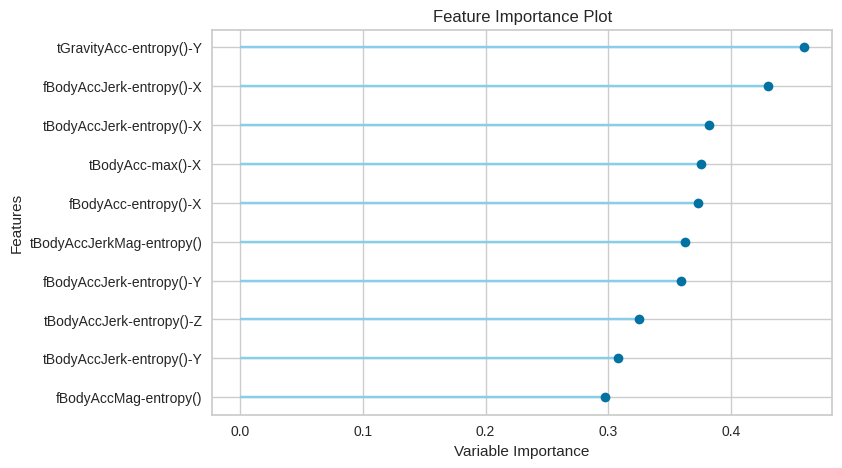

In [41]:
plot_model(best, plot = 'feature')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9970,0.0000,1.0000,0.9933,0.9966,0.9939,0.9939
2,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9970,0.0000,1.0000,0.9933,0.9966,0.9939,0.9939


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


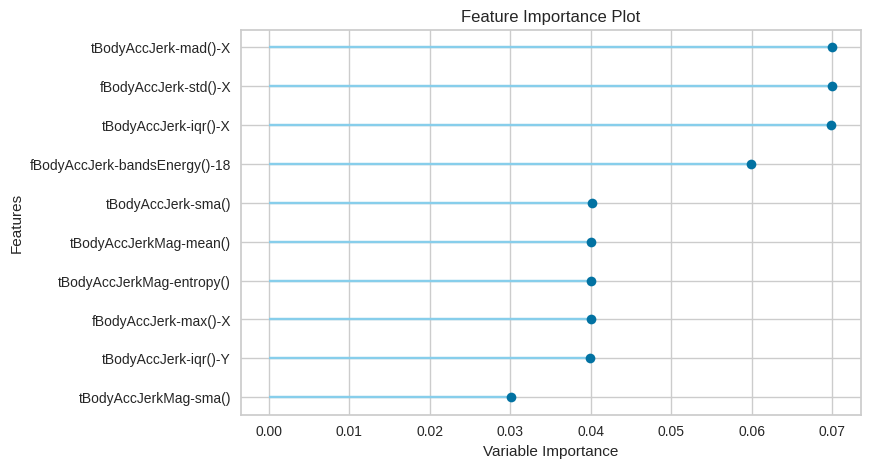

In [44]:
# model_list = ['lr', 'rf', 'xgboost', ]
# saved_models = {}

# for model_name in model_list:
#     model = create_model(model_name)
#     saved_models[model_name] = model
#     save_model(model, f'{model_name}_model')

model_name = 'rf'
model = create_model(model_name)
save_model(model, f'{model_name}_model')
plot_model(model, plot = 'feature')


In [63]:
model_list = ['dt', 'rf', 'xgboost', 'et', 'lightgbm', 'gbc']
data = []
n = 10

for model_name in model_list:
    model = create_model(model_name)

    importances = model.feature_importances_
    feature_data={'feature_name':x_train.columns,'feature_importance':importances}
    feature_df = pd.DataFrame(feature_data).sort_values(by='feature_importance', ascending=False)
    feature_df['model'] = model_name
    data.append(feature_df[:n])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9970,0.0000,1.0000,0.9933,0.9966,0.9939,0.9939
2,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9970,0.0000,1.0000,0.9933,0.9966,0.9939,0.9939
2,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9970,0.0000,1.0000,0.9933,0.9966,0.9939,0.9939


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9970,0.0000,1.0000,0.9933,0.9966,0.9939,0.9939


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9970,0.0000,1.0000,0.9933,0.9966,0.9939,0.9939


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9970,0.0000,1.0000,0.9933,0.9966,0.9939,0.9939


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9970,0.0000,1.0000,0.9933,0.9966,0.9939,0.9939
2,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9970,0.0000,1.0000,0.9933,0.9966,0.9939,0.9939


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [68]:
data[1]

,feature_name,feature_importance,model
86,tBodyAccJerk-mad()-X,0.070025,rf
347,fBodyAccJerk-std()-X,0.069963,rf
99,tBodyAccJerk-iqr()-X,0.069792,rf
381,"fBodyAccJerk-bandsEnergy()-1,8",0.059951,rf
95,tBodyAccJerk-sma(),0.040152,rf
226,tBodyAccJerkMag-mean(),0.040073,rf
234,tBodyAccJerkMag-entropy(),0.040048,rf
353,fBodyAccJerk-max()-X,0.040037,rf
100,tBodyAccJerk-iqr()-Y,0.039868,rf
231,tBodyAccJerkMag-sma(),0.030028,rf


In [70]:
concatenated_features = data[0]
for df in data[1:]:
    concatenated_features = pd.concat([concatenated_features, df], ignore_index=True)
concatenated_features

,feature_name,feature_importance,model
0,"fBodyAccJerk-bandsEnergy()-1,16",1.000000e+00,dt
1,tBodyAcc-mean()-X,0.000000e+00,dt
2,fBodyAccJerk-skewness()-Y,0.000000e+00,dt
3,fBodyAccJerk-maxInds-Z,0.000000e+00,dt
4,fBodyAccJerk-meanFreq()-X,0.000000e+00,dt
5,fBodyAccJerk-meanFreq()-Y,0.000000e+00,dt
6,fBodyAccJerk-meanFreq()-Z,0.000000e+00,dt
7,fBodyAccJerk-skewness()-X,0.000000e+00,dt
8,fBodyAccJerk-kurtosis()-X,0.000000e+00,dt
9,fBodyAccJerk-kurtosis()-Y,0.000000e+00,dt


In [71]:
concatenated_features.set_index(['model', 'feature_name'], inplace=True)

In [75]:
concatenated_features

feature_importance
model    feature_name                                        
dt       fBodyAccJerk-bandsEnergy()-1,16         1.000000e+00
         tBodyAcc-mean()-X                       0.000000e+00
         fBodyAccJerk-skewness()-Y               0.000000e+00
         fBodyAccJerk-maxInds-Z                  0.000000e+00
         fBodyAccJerk-meanFreq()-X               0.000000e+00
         fBodyAccJerk-meanFreq()-Y               0.000000e+00
         fBodyAccJerk-meanFreq()-Z               0.000000e+00
         fBodyAccJerk-skewness()-X               0.000000e+00
         fBodyAccJerk-kurtosis()-X               0.000000e+00
         fBodyAccJerk-kurtosis()-Y               0.000000e+00
rf       tBodyAccJerk-mad()-X                    7.002456e-02
         fBodyAccJerk-std()-X                    6.996311e-02
         tBodyAccJerk-iqr()-X                    6.979174e-02
         fBodyAccJerk-bandsEnergy()-1,8          5.995104e-02
         tBodyAccJerk-sma()                      4.015157e-02
         tBodyAccJerkMag-mean()                  4.007300e-02
         tBodyAccJerkMag-entropy()               4.004847e-02
         fBodyAccJerk-max()-X                    4.003681e-02
         tBodyAccJerk-iqr()-Y                    3.986772e-02
         tBodyAccJerkMag-sma()                   3.002817e-02
xgboost  tBodyAccJerk-mad()-X                    1.000000e+00
         tBodyAcc-mean()-X                       0.000000e+00
         fBodyAccJerk-maxInds-X                  0.000000e+00
         fBodyAccJerk-maxInds-Z                  0.000000e+00
         fBodyAccJerk-meanFreq()-X               0.000000e+00
         fBodyAccJerk-meanFreq()-Y               0.000000e+00
         fBodyAccJerk-meanFreq()-Z               0.000000e+00
         fBodyAccJerk-skewness()-X               0.000000e+00
         fBodyAccJerk-kurtosis()-X               0.000000e+00
         fBodyAccJerk-skewness()-Y               0.000000e+00
et       fBodyAcc-std()-X                        3.668831e-02
         fBodyAcc-mean()-X                       3.211009e-02
         tBodyAccJerk-entropy()-Y                3.029845e-02
         tBodyAcc-max()-X                        2.962376e-02
         fBodyBodyAccJerkMag-mad()               1.982857e-02
         fBodyAccJerk-mad()-X                    1.956493e-02
         tBodyGyro-iqr()-Y                       1.911446e-02
         fBodyBodyGyroMag-entropy()              1.825898e-02
         fBodyGyro-mean()-Z                      1.809766e-02
         tBodyAccJerk-max()-Y                    1.805885e-02
lightgbm tBodyAccJerk-arCoeff()-X,1              7.700000e+01
         tGravityAcc-entropy()-Y                 7.700000e+01
         fBodyAccMag-skewness()                  7.500000e+01
         angle(tBodyGyroMean,gravityMean)        7.400000e+01
         tBodyAcc-mean()-Z                       7.000000e+01
         fBodyAcc-skewness()-Z                   6.500000e+01
         tBodyAcc-max()-X                        6.100000e+01
         tBodyAccJerk-min()-X                    6.000000e+01
         tBodyGyro-entropy()-Z                   6.000000e+01
         fBodyAccMag-mean()                      5.900000e+01
gbc      fBodyAccJerk-bandsEnergy()-1,16         5.560686e-01
         fBodyAccJerk-max()-X                    2.551572e-01
         tBodyAccJerk-mad()-X                    1.887742e-01
         tBodyAccJerk-arCoeff()-Z,4              8.696474e-15
         fBodyGyro-bandsEnergy()-17,24.2         7.251037e-15
         fBodyGyro-bandsEnergy()-1,16.1          6.813420e-15
         tBodyAcc-max()-Z                        3.534795e-15
         fBodyAcc-max()-X                        2.672788e-15
         fBodyAccJerk-bandsEnergy()-17,32        2.422541e-15
         tBodyAcc-arCoeff()-Y,1                  2.415246e-15

In [79]:
concatenated_features[:1]

,,feature_importance
model,feature_name,
dt,"fBodyAccJerk-bandsEnergy()-1,16",1.0


### 딥러닝 :

In [ ]:
# 347	fBodyAccJerk-std()-X	0.059837
# 381	fBodyAccJerk-bandsEnergy()-1,8	0.050130
# 350	fBodyAccJerk-mad()-X	0.049897
# 389	fBodyAccJerk-bandsEnergy()-1,16	0.040178
# 83	tBodyAccJerk-std()-X	0.040017

In [81]:
n_features = x_train.shape[1]
n_features

561

In [82]:
clear_session()

model = Sequential([Dense(128, input_shape=(n_features, ), activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               71936     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 82305 (321.50 KB)
Trainable params: 82305 (321.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
model.compile(Adam(0.001), loss='binary_crossentropy')

In [84]:
y_train

2861    0
5334    0
2941    1
527     0
1405    0
       ..
3971    1
571     1
1197    0
2801    0
3491    0
Name: Activity, Length: 4704, dtype: int64

In [85]:
hist1 = model.fit(x_train, y_train, epochs=100, verbose=0, validation_split=.2).history

In [38]:
model.layers[0].get_weights()[0]

array([[ 0.00041681,  0.09122474, -0.01290467, ..., -0.08529477,
        -0.03170259, -0.02895515],
       [-0.0829847 ,  0.06217328, -0.03500548, ...,  0.05973024,
         0.05265033, -0.00219301],
       [-0.08837605, -0.12114099,  0.07457067, ..., -0.02008433,
        -0.05700227,  0.04372806],
       ...,
       [-0.04726727, -0.02644096, -0.02876113, ...,  0.08462469,
        -0.01545376, -0.04088693],
       [ 0.15018132,  0.06395712,  0.03213924, ...,  0.07705114,
        -0.08544639,  0.0131211 ],
       [ 0.08435933, -0.02338949, -0.06919884, ..., -0.07354004,
        -0.03464346, -0.07392304]], dtype=float32)

In [80]:
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

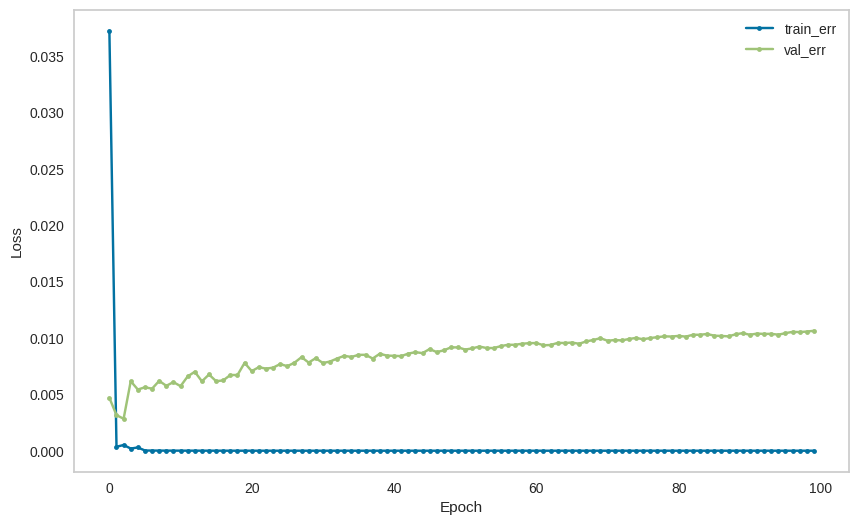

In [86]:
dl_history_plot(hist1)